# Setting up Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

cols = [0, 1, 2, 3, 4, 9, 13, 15, 16, 17, 25, 27]
heads = ['ID', '$M_1$', '$M_2$', '$S_1$', '$S_2$', '$t_{pair}$', '$t_{elapsed}$',
         '$M_{rem}$', '$S_{rem}$', '$v_{escape}$', '$M_{tot}$', 'Gen']



def extractor(path_data: str, cluster: str):
    '''Path data should include the final "/" e.g.: data/. Also we're using Dyn.'''
    metal = {}
    if cluster == 'gc': new_path = path_data + 'GC_chi01_output_noclusterevolv/Dyn/'
    if cluster == 'nsc': new_path = path_data + 'NSC_chi01_output_noclusterevolv/Dyn/'
    if cluster == 'ysc': new_path = path_data + 'YSC_chi01_output_noclusterevolv/Dyn/'
    for z in os.listdir(new_path):
        name = new_path + str(z) + '/nth_generation.txt'
        metal[z] = pd.read_csv(name, delimiter=' ', skiprows=1, usecols=cols, names=heads)
    whole = pd.concat(metal.values())
    return metal, whole


df_gc, whole_gc = extractor('data/','gc')  # globular clusters
df_nsc, whole_nsc = extractor('data/','nsc')  # nuclear clusters
df_ysc, whole_ysc = extractor('data/','ysc')  # young star clusters

# Grafici

## Masses

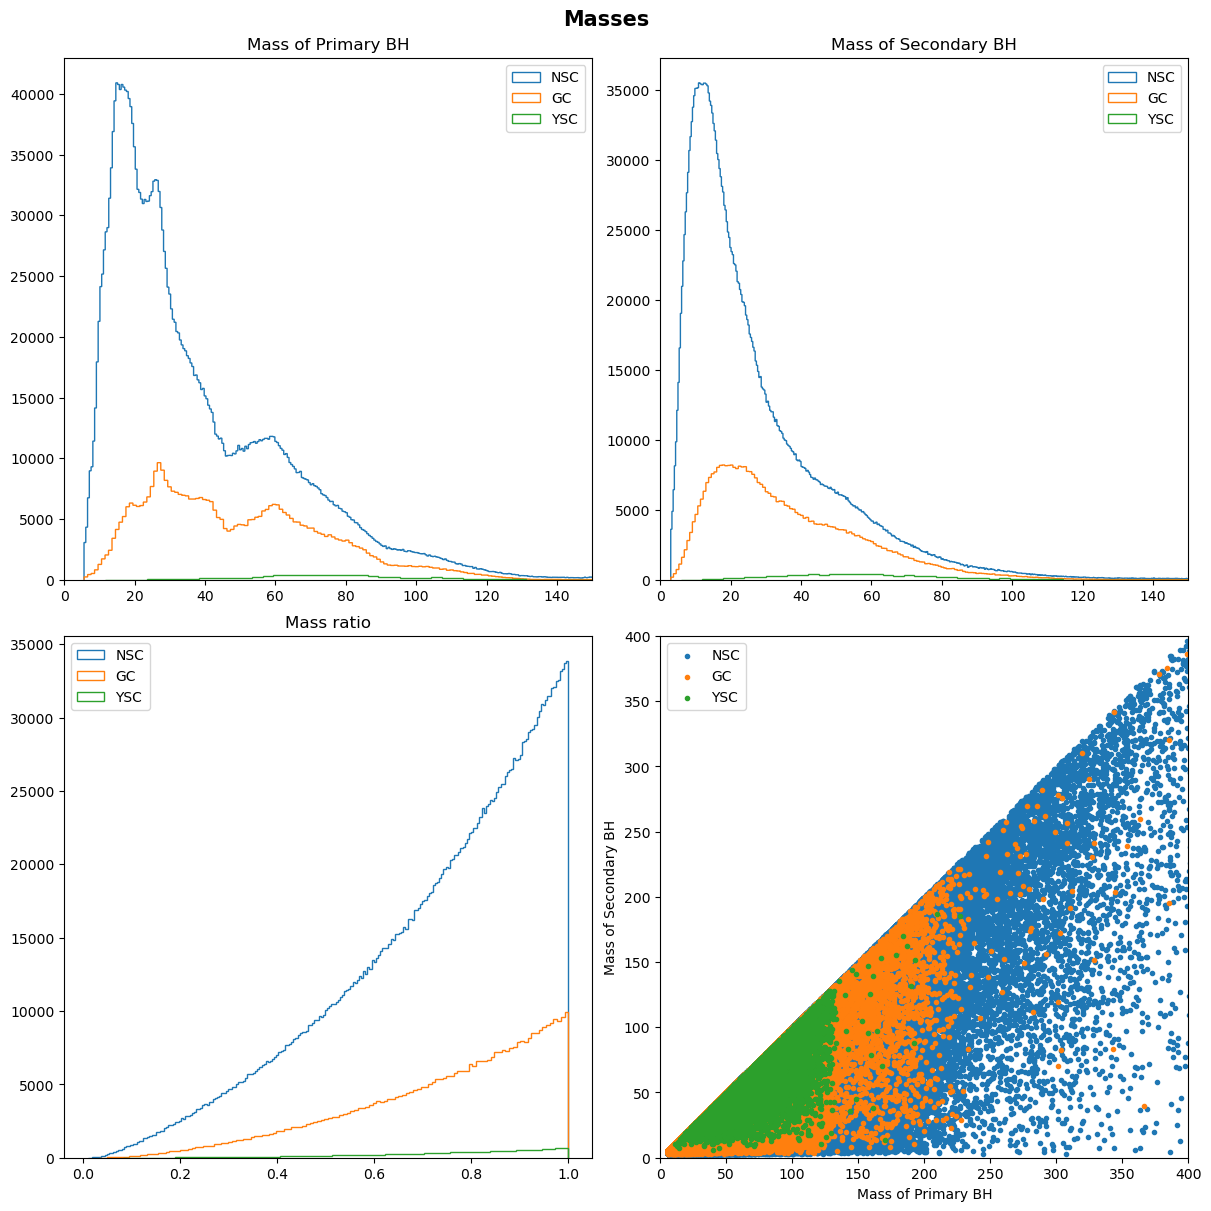

In [2]:
fig, ax = plt.subplots(2, 2, figsize=(12,12), layout='constrained')
fig.suptitle('Masses', fontsize=15, weight='bold')

for typo, data in {'NSC':whole_nsc, 'GC':whole_gc, 'YSC':whole_ysc}.items():  # Yes, I do like dictionairies
    ax[0,0].hist(data['$M_1$'], 'auto', histtype='step', label=typo)
    ax[0,1].hist(data['$M_2$'], 'auto', histtype='step', label=typo)
    ax[1,0].hist(data['$M_2$'] / data['$M_1$'], 'auto', histtype='step', label=typo)
    ax[1,1].scatter(data['$M_1$'], data['$M_2$'], marker='.', label=typo)  # Of course the limit will be a y=x line,
# since y can't exceed x

ax[0,0].set_title('Mass of Primary BH')
ax[0,0].legend(loc='upper right')
ax[0,0].set_xlim(0,150)  # There are way larger values, but they aren't visible

ax[0,1].set_title('Mass of Secondary BH')
ax[0,1].set_xlim(0,150)
ax[0,1].legend(loc='upper right')

ax[1,0].set_title('Mass ratio')
ax[1,0].legend(loc='upper left')

ax[1,1].set_title('')
ax[1,1].legend(loc='upper left')
ax[1,1].set_xlabel('Mass of Primary BH')
ax[1,1].set_ylabel('Mass of Secondary BH')
ax[1,1].set_xlim(0,400)  # To show the Clusters with less BHs
ax[1,1].set_ylim(0,400)
plt.show()


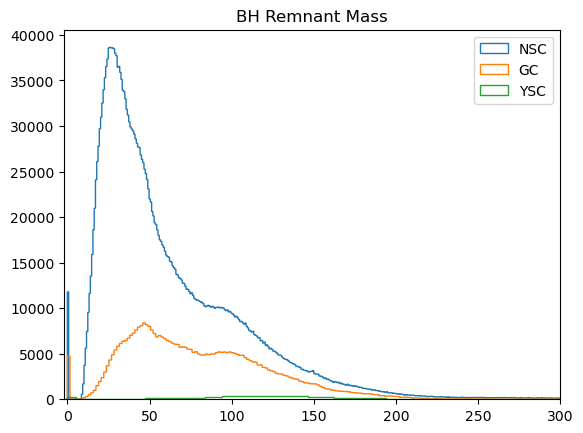

In [3]:
fig, ax = plt.subplots()
for typo, data in {'NSC':whole_nsc, 'GC':whole_gc, 'YSC':whole_ysc}.items(): ax.hist(data['$M_{rem}$'], 'auto', histtype='step', label=typo)
ax.set_title('BH Remnant Mass')
ax.legend(loc='upper right')
ax.set_xlim(-2, 300)
plt.show()

# Spin

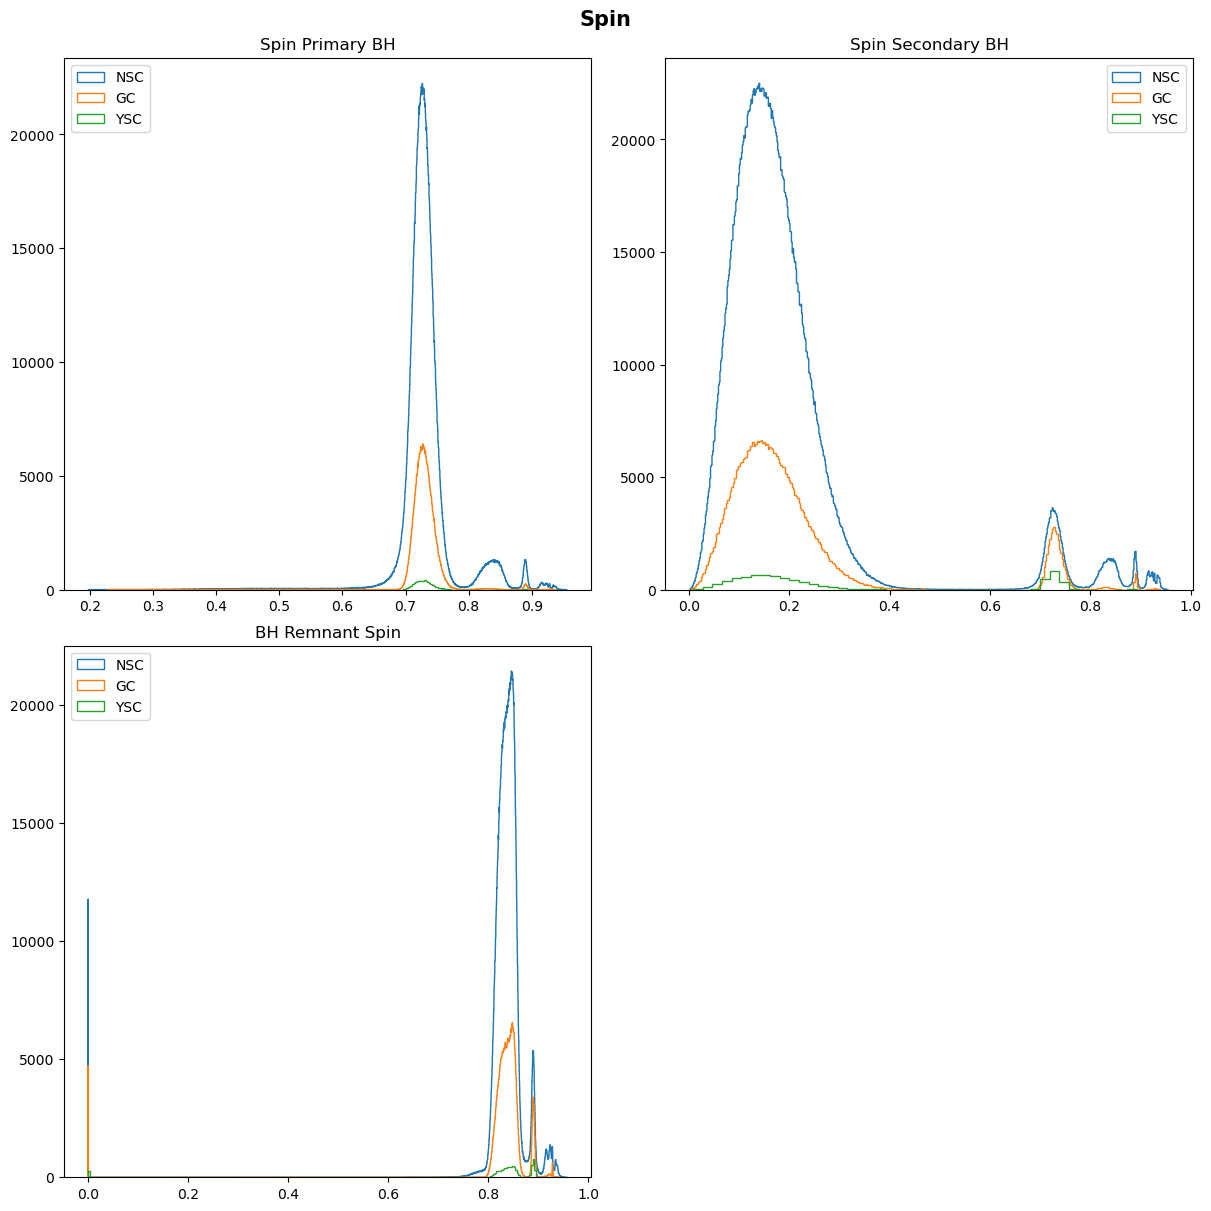

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(12,12), layout='constrained')
fig.suptitle('Spin', fontsize=15, weight='bold')

for typo, data in {'NSC':whole_nsc, 'GC':whole_gc, 'YSC':whole_ysc}.items():
    ax[0,0].hist(data['$S_1$'], 'auto', histtype='step', label=typo)
    ax[0,1].hist(data['$S_2$'], 'auto', histtype='step', label=typo)
    ax[1,0].hist(data['$S_{rem}$'], 'auto', histtype='step', label=typo)
    
ax[0,0].set_title('Spin Primary BH')
ax[0,0].legend(loc='upper left')

ax[0,1].set_title('Spin Secondary BH')
ax[0,1].legend(loc='upper right')

ax[1,0].set_title('BH Remnant Spin')
ax[1,0].legend(loc='upper left')

ax[1,1].set_axis_off()
plt.show()

# The Other Stuff

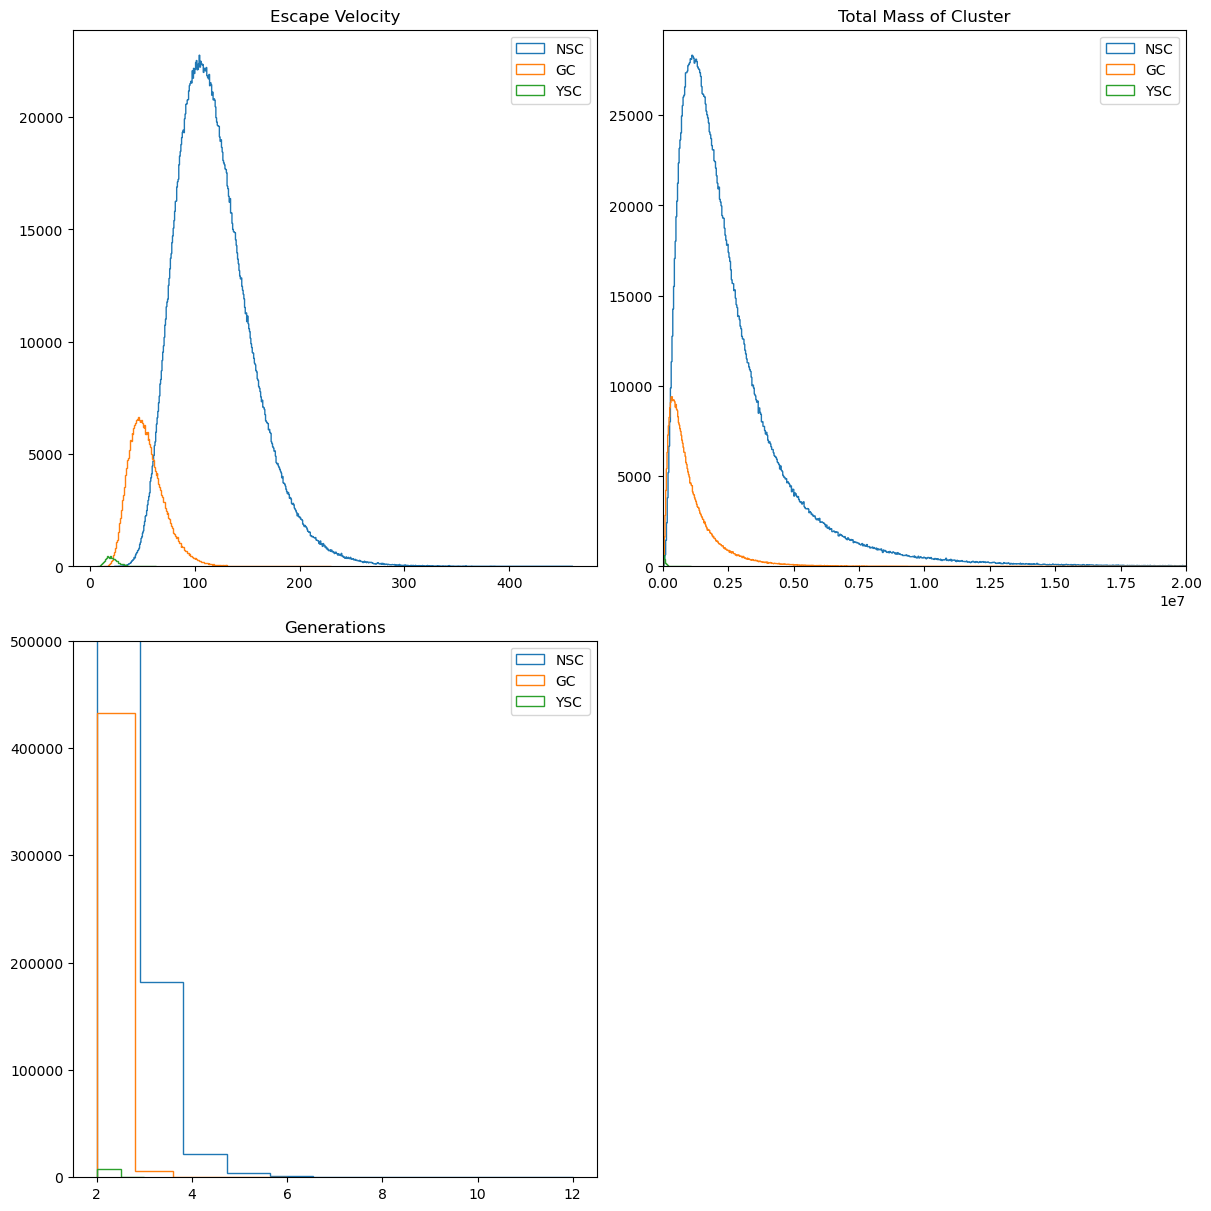

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(12,12), layout='constrained')

for typo, data in {'NSC':whole_nsc, 'GC':whole_gc, 'YSC':whole_ysc}.items():
    ax[0,0].hist(data['$v_{escape}$'], 'auto', histtype='step', label=typo)
    ax[0,1].hist(data['$M_{tot}$'], 'auto', histtype='step', label=typo) 
    ax[1,0].hist(data['Gen'], data['Gen'].nunique(), histtype='step', label=typo)

ax[0,0].set_title('Escape Velocity')
ax[0,0].legend(loc='upper right')

ax[0,1].set_title('Total Mass of Cluster')
ax[0,1].legend(loc='upper right')
ax[0,1].set_xlim(-1, 2e7)

ax[1,0].set_title('Generations')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylim(0, 5e5)

ax[1,1].set_axis_off()
plt.show()